In [1]:
import pyarrow
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
# Filter wrong tiles (had human tiles in there before)
input_filename = 'results/finches_all-enriched-viral-and-human-peptide-to-human-tiled-idr-interaction_results.parquet'
corrected_filename = 'results/finches_all-enriched-viral-peptide-to-human-tiled-idr-interaction_results.parquet'

df = pq.read_table(input_filename).to_pandas()

# Filter out rows where 's1_id' starts with 'HN_' or 'HP_'
df_filtered = df[~df['s1_id'].str.startswith(('HN_', 'HP_'))]

# Save the filtered DataFrame back to the same parquet file
df_filtered.to_parquet(corrected_filename, index=False)

print(f"Filtered out rows where 's1_id' started with 'HN_' or 'HP_'.")
print(f"Original number of rows: {len(df)}")
print(f"Filtered number of rows: {len(df_filtered)}")
print(f"Saved the filtered data to: {corrected_filename}")

Filtered out rows where 's1_id' started with 'HN_' or 'HP_'.
Original number of rows: 304936977
Filtered number of rows: 266282994
Saved the filtered data to: results/finches_all-enriched-viral-peptide-to-human-tiled-idr-interaction_results.parquet


In [2]:
input_filename = 'results/finches_all-enriched-viral-peptide-to-human-tiled-idr-interaction_results.parquet'

#df = pq.read_table(input_filename).to_pandas()
df = pq.read_table(
    input_filename,
    columns=['s1_id', 's2_id', 'mf_s1_s2', 'mf_s2_s1', 'cf_s1_s2', 'cf_s2_s1',
             'mean_epsilon', 'std_epsilon', 'interaction_type', 's1_length', 's2_length']
).to_pandas()
print(df.columns)

df['interaction_type'] = df['interaction_type'].astype('category')
# Optimize numeric columns (if precision allows)
for col in ['mean_epsilon', 'std_epsilon', 'mf_s1_s2', 'mf_s2_s1', 'cf_s1_s2', 'cf_s2_s1']:
    if col in df.columns:
        df[col] = df[col].astype(np.float16)

print(len(df[df['interaction_type'] == 'attraction']))
print(len(df[df['interaction_type'] == 'repulsion']))


# s1 is the short víral peptide, s2 is the human idrs (min 23 AA long = similar length to the ~48 AA viral peptide)
#df['length_similarity'] = np.where(df['s2_sequence'].str.len() < df['s1_sequence'].str.len() * 2, 'similar length', 'different length')


#df = df[df['length_similarity'] == 'similar length']
df_ = df
columns_to_check = ['mf_s1_s2', 'mf_s2_s1', 'cf_s1_s2', 'cf_s2_s1']
df = df[~((df[columns_to_check] > -3) & (df[columns_to_check] < 3)).any(axis=1)]
print(len(df))

df['len_ratio'] = df['s2_length'] / df['s1_length']

Index(['s1_id', 's2_id', 'mf_s1_s2', 'mf_s2_s1', 'cf_s1_s2', 'cf_s2_s1',
       'mean_epsilon', 'std_epsilon', 'interaction_type', 's1_length',
       's2_length'],
      dtype='object')
90396383
175886611
16598371


/scratch/1375004.1.apolkovnikov-pub/ipykernel_2403259/1385642585.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_ratio'] = df['s2_length'] / df['s1_length']


In [3]:
df_interactions = pd.read_csv('data/human-proteom-interactions.csv')

# Create a mapping Series from df_interactions
# The index will be 'ID' and the values will be 'P53_Interaction'
id_to_p53_interaction_map = df_interactions.set_index('ID')['P53_Interaction']

df['P53_Interaction'] = df['s2_id'].map(id_to_p53_interaction_map)
df_['P53_Interaction'] = df_['s2_id'].map(id_to_p53_interaction_map)

/scratch/1375004.1.apolkovnikov-pub/ipykernel_2403259/3129619179.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['P53_Interaction'] = df['s2_id'].map(id_to_p53_interaction_map)


In [19]:
df[(df['s1_id']=='VT_20379_AVA07189.1') & (df['s2_id'] == 'NP_001027451.1')]

/projectnb/cancergrp/Philipp/.conda/envs/jupyter_env/lib/python3.13/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


s1_id           s2_id  mf_s1_s2  mf_s2_s1  cf_s1_s2  \
251981829  VT_20379_AVA07189.1  NP_001027451.1 -3.699219 -3.623047 -3.431641   

           cf_s2_s1  mean_epsilon  std_epsilon interaction_type  s1_length  \
251981829 -3.361328     -3.529297     0.137085       attraction       49.0   

           s2_length  len_ratio P53_Interaction  
251981829       48.0   0.979592         primary

In [6]:
#Filter the top interactions for AlphaFold3 pipeline

# This file includes all the top viral hits from the RITA experiment
significant_viral_tiles = pd.read_csv("data/tiling_peptides_thresholded_foldchange.csv") 

viral_ids = significant_viral_tiles['tileID']
viral_seq = significant_viral_tiles['Aminoacids']
viral_id_seq_map = significant_viral_tiles.set_index('tileID')['Aminoacids'].to_dict()

df['s1_viral_id_prefix'] = df['s1_id'].str.split('_', n=1).str[0]
#df_filtered = df[((df['s1_id'].apply(lambda x: '_'.join(x.split('_')[:2]))).isin(viral_ids)) & (df['P53_Interaction'] == 'primary') & (df['interaction_type'] == 'attraction') & (df['mf_s1_s2'] < -3.5) & (df['mf_s2_s1'] < -3)]
df_filtered = df[((df['s1_id'].apply(lambda x: '_'.join(x.split('_')[:2]))).isin(viral_ids)) & (df['P53_Interaction'] == 'primary') & (df['interaction_type'] == 'attraction')]
df_filtered.to_csv('data/strong_siginficant_viral_tiles_interacting_with_primary_P53_interactors.csv')


df_filtered_seq = pd.DataFrame(columns= ['ID_A_Interactor', 'ID_B_Interactor', 'Sequence_A', 'Sequence_B'])
df_filtered_seq['ID_A_Interactor'] = df_filtered['s1_id']
df_filtered_seq['ID_B_Interactor'] = df_filtered['s2_id']

df_filtered_seq['Sequence_A'] = (df_filtered_seq['ID_A_Interactor'].apply(lambda x: '_'.join(x.split('_')[:2]))).map(viral_id_seq_map)

df_interactions = pd.read_csv('data/human-proteom-interactions.csv')

# Create a mapping Series from df_interactions
id_to_seq_interaction_map = df_interactions.set_index('ID')['Sequence']

df_filtered_seq['Sequence_B'] = df_filtered_seq['ID_B_Interactor'].map(id_to_seq_interaction_map)
print(f"Shape before filtering for duplicates: {df_filtered_seq.shape}")
df_filtered_seq_unique = df_filtered_seq.drop_duplicates(subset=['ID_A_Interactor', 'ID_B_Interactor'])
print(f"Shape after filtering for duplicates: {df_filtered_seq_unique.shape}")
df_filtered_seq_unique.to_csv('alphafold3_pipeline/inputs/strong_significant_viral_tiles_with_primary_P53_interactors.csv')


/scratch/1375004.1.apolkovnikov-pub/ipykernel_2403259/3604635523.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['s1_viral_id_prefix'] = df['s1_id'].str.split('_', n=1).str[0]


Shape before filtering for duplicates: (1694, 4)
Shape after filtering for duplicates: (1033, 4)


In [3]:
df_na = df[df['interaction_type'] == 'N/A']
print(len(df_na))
na_viruses = df['s1_id'].unique()
print(len(na_viruses))

0
213


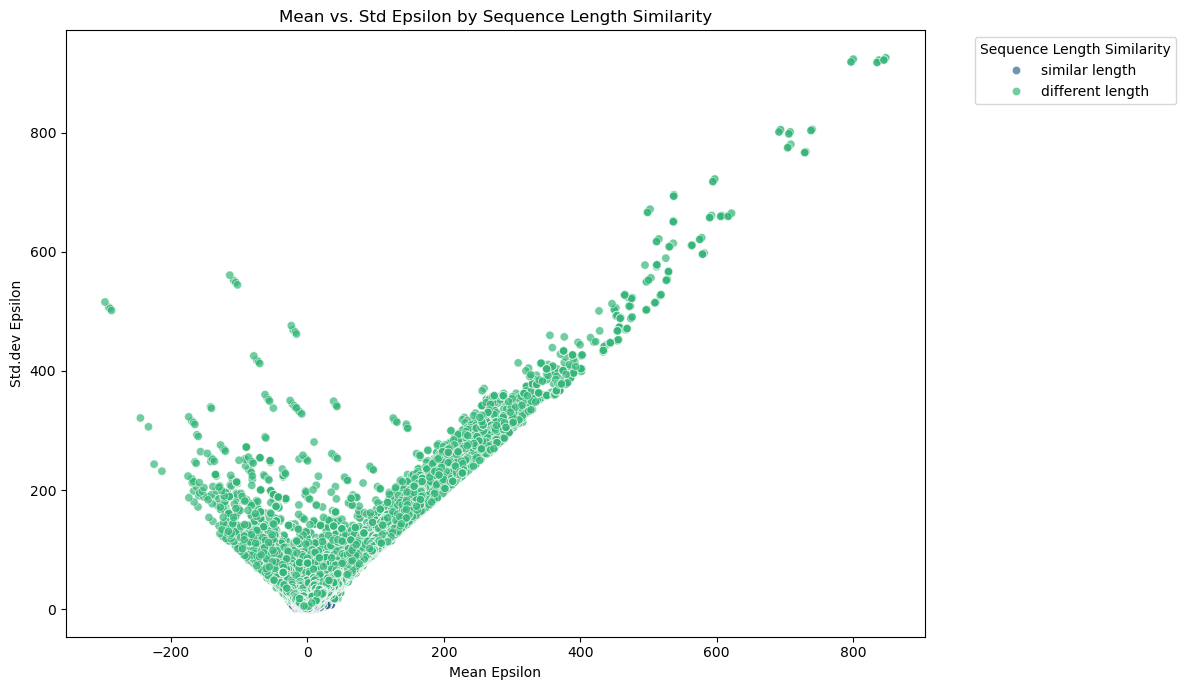

In [ ]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='mean_epsilon', y='std_epsilon',
                hue='length_similarity', alpha=0.7, palette='viridis')
plt.title('Mean vs. Std Epsilon by Sequence Length Similarity')
plt.xlabel('Mean Epsilon')
plt.ylabel('Std.dev Epsilon')
plt.legend(title='Sequence Length Similarity', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout() 
plt.show()

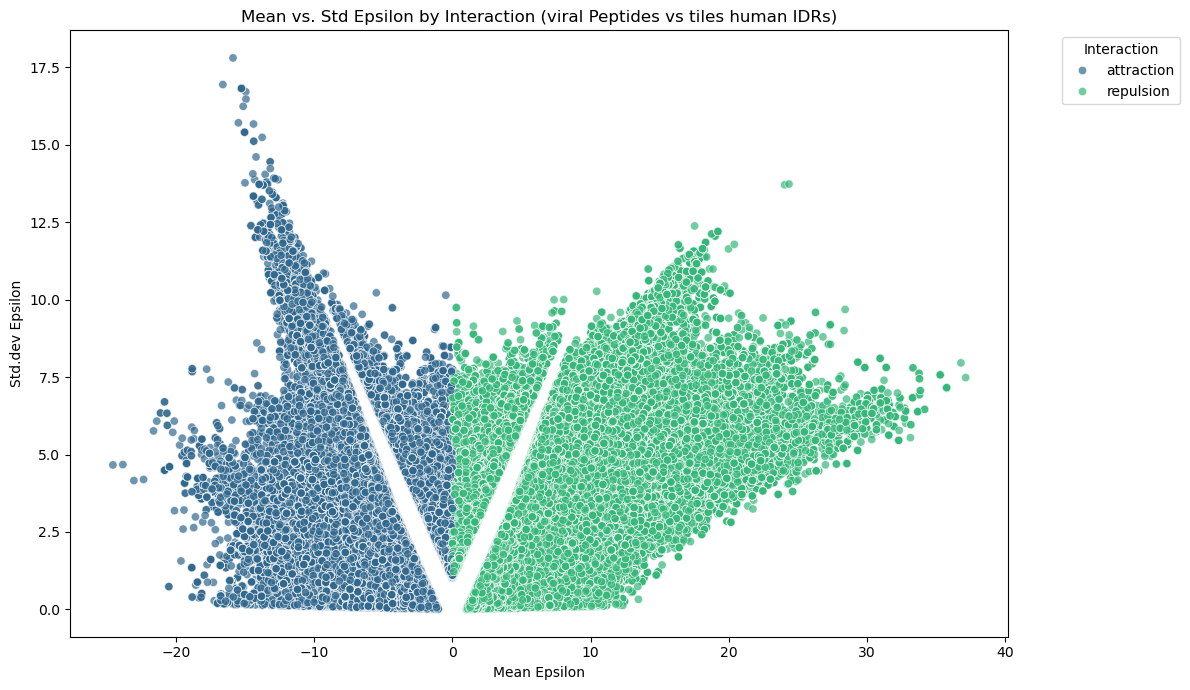

In [4]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='mean_epsilon', y='std_epsilon',
                hue='interaction_type', alpha=0.7, palette='viridis')
plt.title('Mean vs. Std Epsilon by Interaction (viral Peptides vs tiles human IDRs)')
plt.xlabel('Mean Epsilon')
plt.ylabel('Std.dev Epsilon')
plt.legend(title='Interaction', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout() 
plt.show()

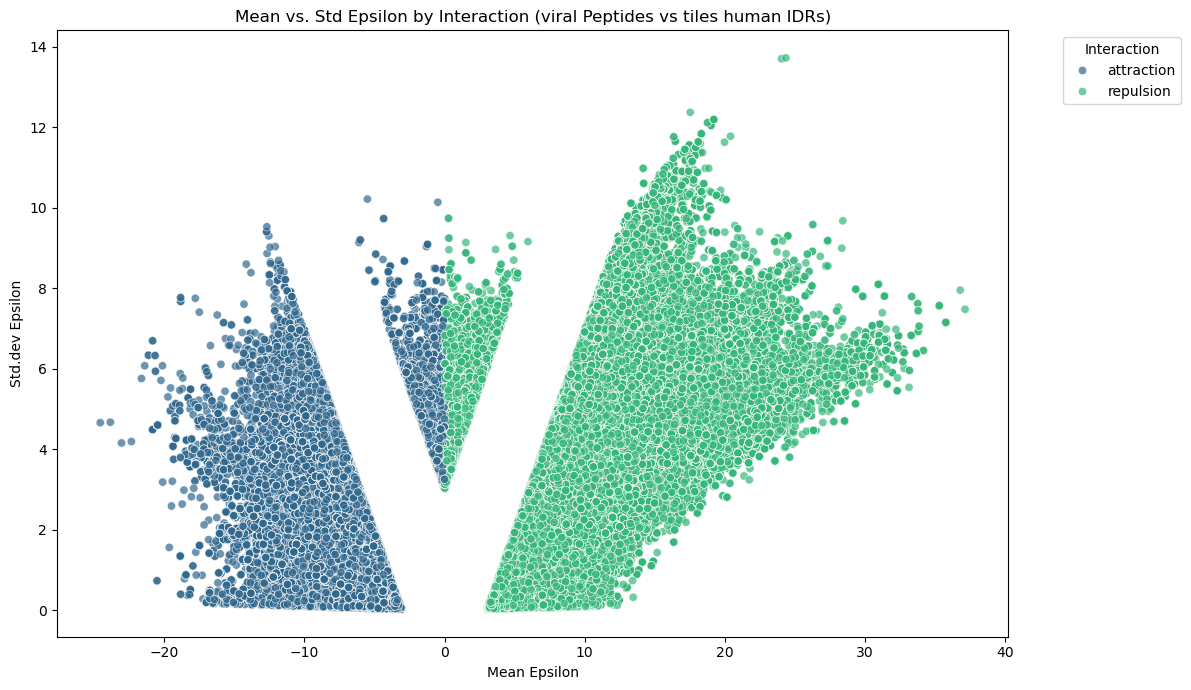

In [3]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='mean_epsilon', y='std_epsilon',
                hue='interaction_type', alpha=0.7, palette='viridis')
plt.title('Mean vs. Std Epsilon by Interaction (viral Peptides vs tiles human IDRs)')
plt.xlabel('Mean Epsilon')
plt.ylabel('Std.dev Epsilon')
plt.legend(title='Interaction', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout() 
plt.show()

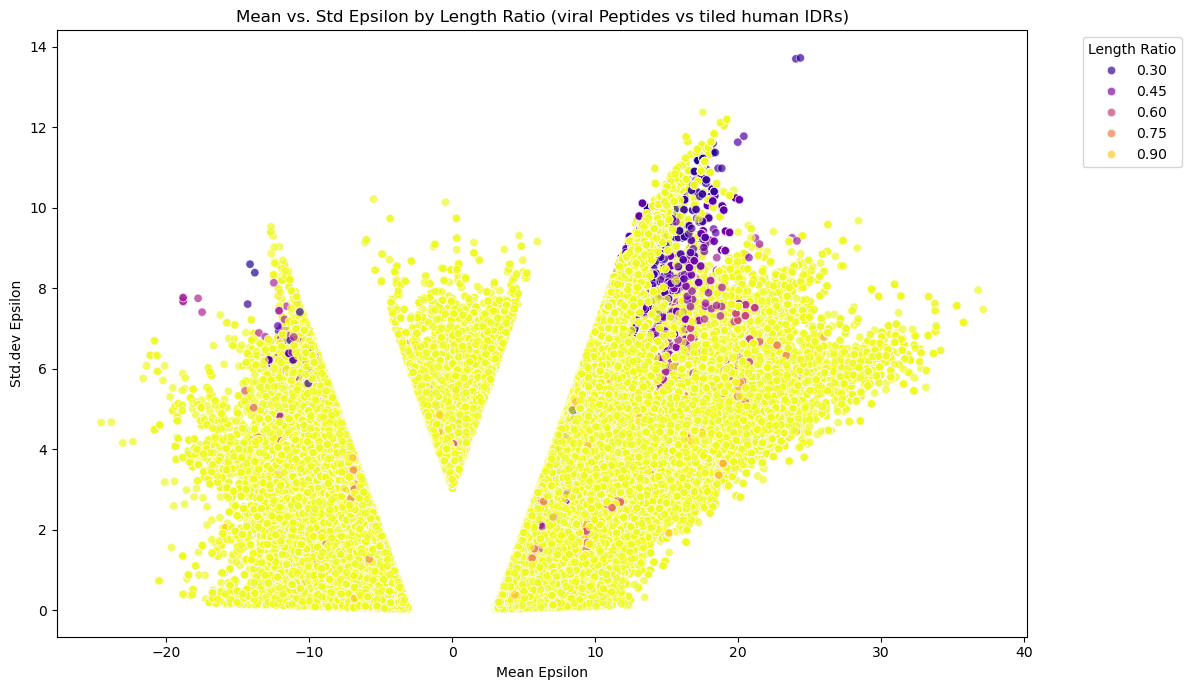

In [12]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='mean_epsilon', y='std_epsilon',
                hue='len_ratio', alpha=0.7, palette='plasma') 
plt.title('Mean vs. Std Epsilon by Length Ratio (viral Peptides vs tiled human IDRs)')
plt.xlabel('Mean Epsilon')
plt.ylabel('Std.dev Epsilon')
plt.legend(title='Length Ratio', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

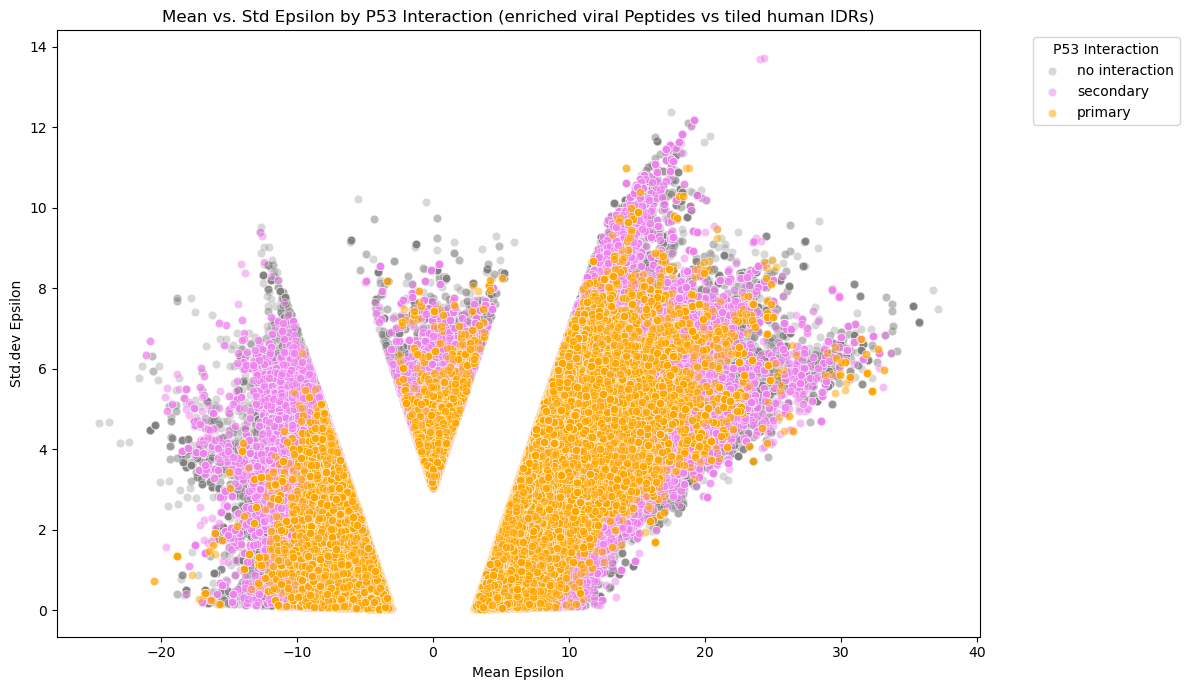

In [24]:
plt.figure(figsize=(12, 7))

# Define custom colors for each P53_Interaction category
custom_colors = {
    'primary': 'orange',
    'secondary': 'violet',
    'no interaction': 'gray'
}

# Plot 'no interaction' points first with lower transparency
# Plotting this group first ensures it appears underneath the others
sns.scatterplot(
    data=df[df['P53_Interaction'] == 'no interaction'],
    x='mean_epsilon',
    y='std_epsilon',
    color=custom_colors['no interaction'], # Set the color to gray
    alpha=0.3,  # Set transparency to be more transparent (e.g., 0.3)
    label='no interaction' # Add a label for the legend
)

# Plot 'secondary' points with higher transparency
sns.scatterplot(
    data=df[df['P53_Interaction'] == 'secondary'],
    x='mean_epsilon',
    y='std_epsilon',
    color=custom_colors['secondary'], # Set the color to violet
    alpha=0.5,  # Set transparency to be less transparent
    label='secondary' # Add a label for the legend
)

# Plot 'primary' points with higher transparency
sns.scatterplot(
    data=df[df['P53_Interaction'] == 'primary'],
    x='mean_epsilon',
    y='std_epsilon',
    color=custom_colors['primary'], # Set the color to orange
    alpha=0.5,  # Set transparency to be less transparent
    label='primary' # Add a label for the legend
)

plt.title('Mean vs. Std Epsilon by P53 Interaction (enriched viral Peptides vs tiled human IDRs)')
plt.xlabel('Mean Epsilon')
plt.ylabel('Std.dev Epsilon')

# The legend will automatically collect the 'label' from each scatterplot call
plt.legend(title='P53 Interaction', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

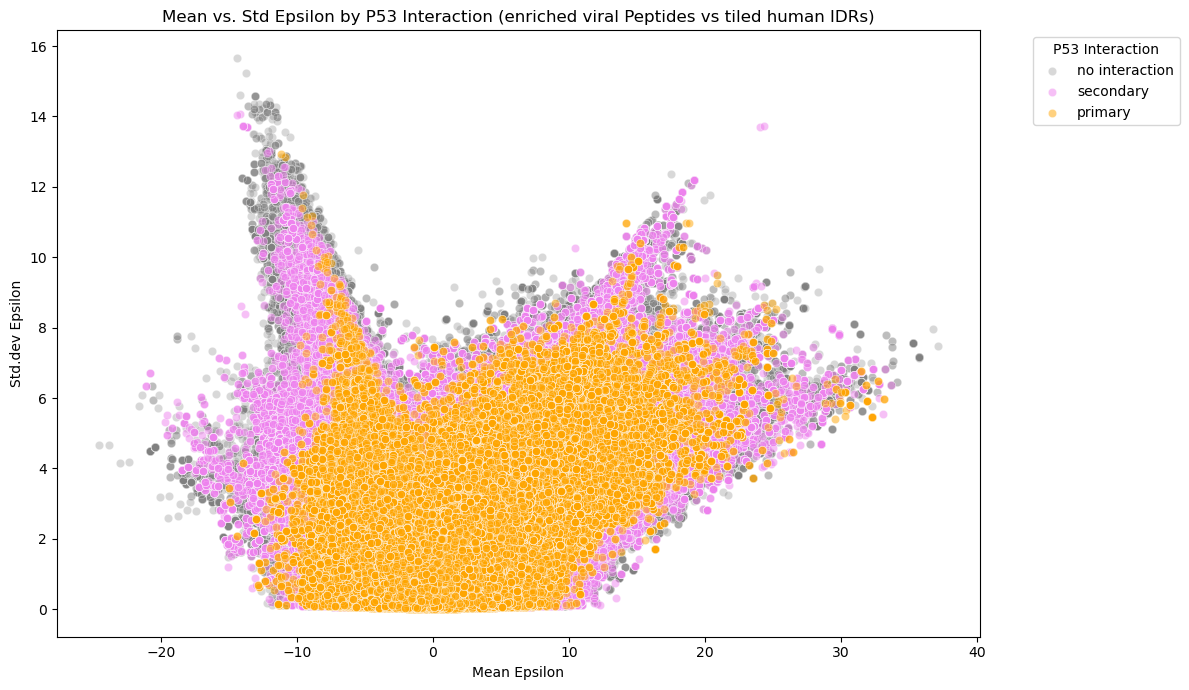

In [6]:
plt.figure(figsize=(12, 7))

# Define custom colors for each P53_Interaction category
custom_colors = {
    'primary': 'orange',
    'secondary': 'violet',
    'no interaction': 'gray'
}

# Plot 'no interaction' points first with lower transparency
# Plotting this group first ensures it appears underneath the others
sns.scatterplot(
    data=df_[df_['P53_Interaction'] == 'no interaction'],
    x='mean_epsilon',
    y='std_epsilon',
    color=custom_colors['no interaction'], # Set the color to gray
    alpha=0.3,  # Set transparency to be more transparent (e.g., 0.3)
    label='no interaction' # Add a label for the legend
)

# Plot 'secondary' points with higher transparency
sns.scatterplot(
    data=df_[df_['P53_Interaction'] == 'secondary'],
    x='mean_epsilon',
    y='std_epsilon',
    color=custom_colors['secondary'], # Set the color to violet
    alpha=0.5,  # Set transparency to be less transparent
    label='secondary' # Add a label for the legend
)

# Plot 'primary' points with higher transparency
sns.scatterplot(
    data=df_[df_['P53_Interaction'] == 'primary'],
    x='mean_epsilon',
    y='std_epsilon',
    color=custom_colors['primary'], # Set the color to orange
    alpha=0.5,  # Set transparency to be less transparent
    label='primary' # Add a label for the legend
)

plt.title('Mean vs. Std Epsilon by P53 Interaction (enriched viral Peptides vs tiled human IDRs)')
plt.xlabel('Mean Epsilon')
plt.ylabel('Std.dev Epsilon')

# The legend will automatically collect the 'label' from each scatterplot call
plt.legend(title='P53 Interaction', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

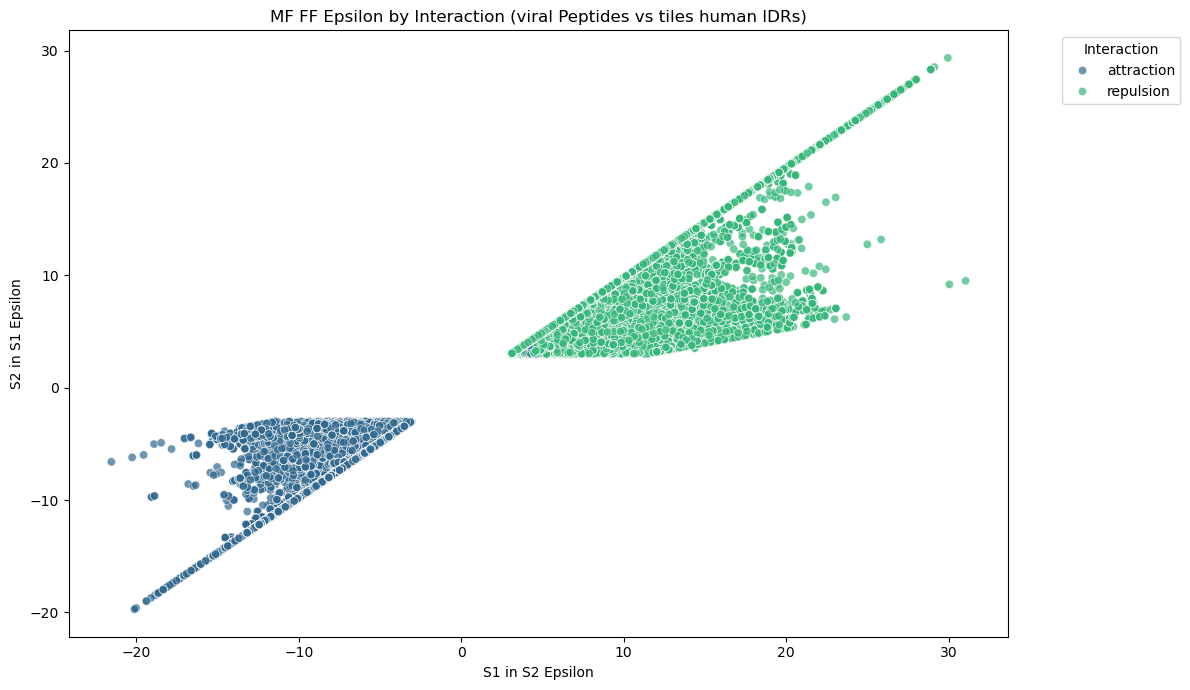

In [4]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='mf_s1_s2', y='mf_s2_s1',
                hue='interaction_type', alpha=0.7, palette='viridis')
plt.title('MF FF Epsilon by Interaction (viral Peptides vs tiles human IDRs)')
plt.xlabel('S1 in S2 Epsilon')
plt.ylabel('S2 in S1 Epsilon')
plt.legend(title='Interaction', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout() 
plt.show()

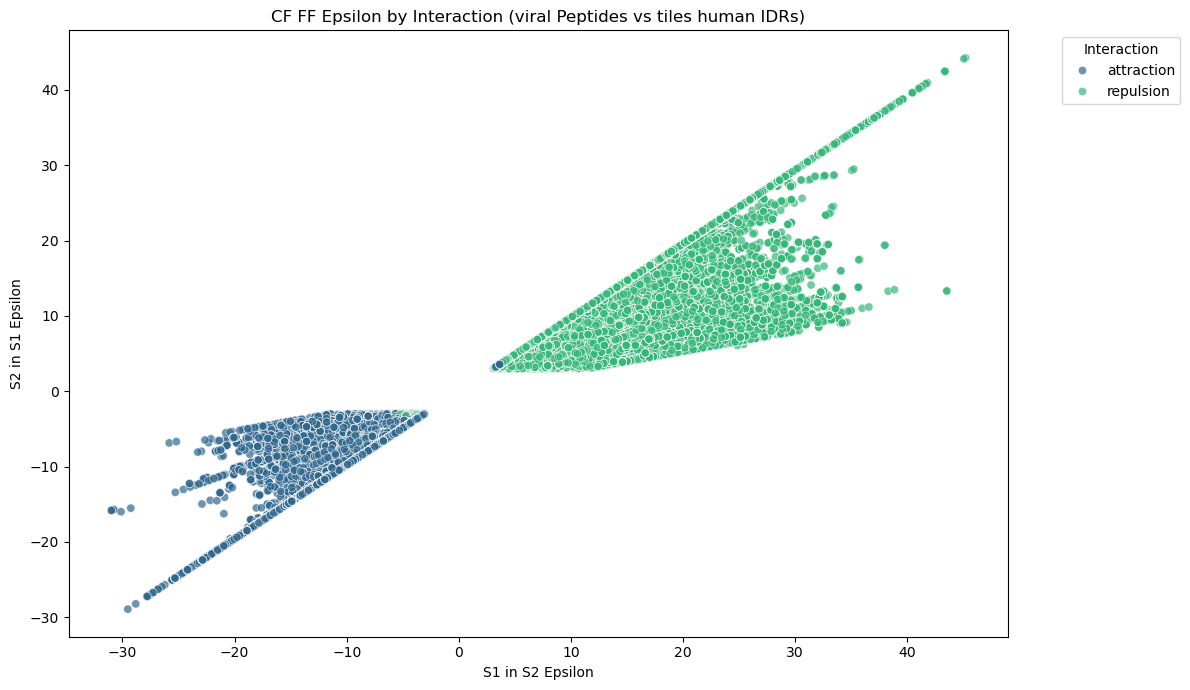

In [5]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='cf_s1_s2', y='cf_s2_s1',
                hue='interaction_type', alpha=0.7, palette='viridis')
plt.title('CF FF Epsilon by Interaction (viral Peptides vs tiles human IDRs)')
plt.xlabel('S1 in S2 Epsilon')
plt.ylabel('S2 in S1 Epsilon')
plt.legend(title='Interaction', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout() 
plt.show()

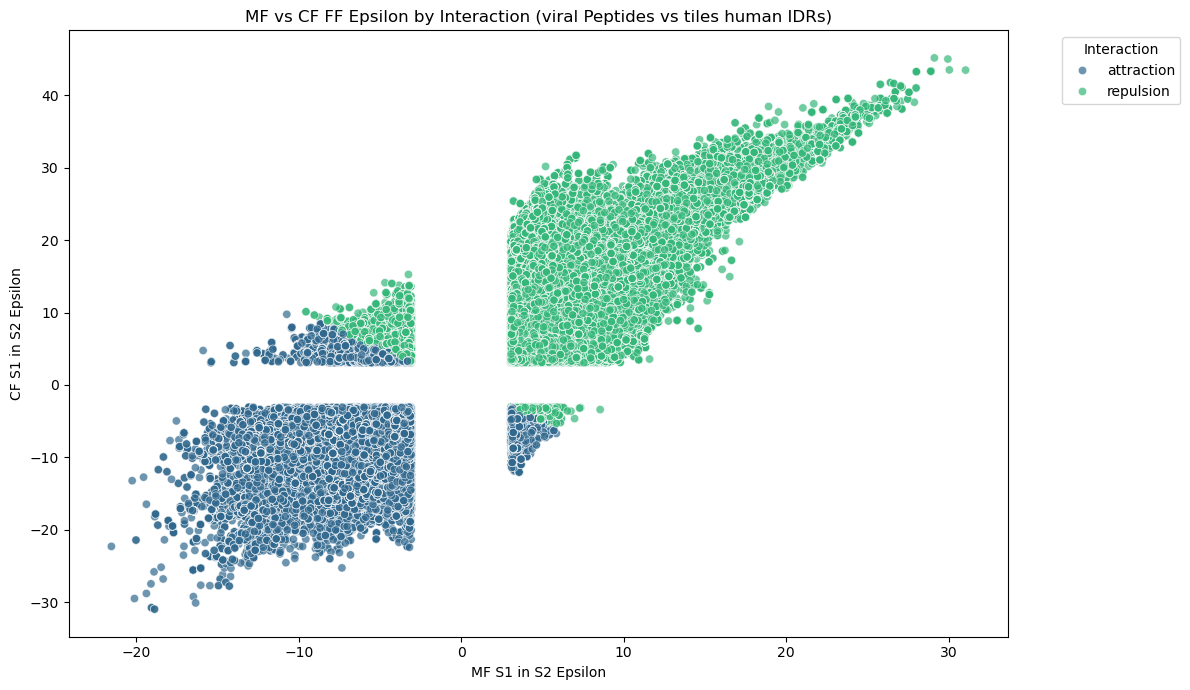

In [6]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='mf_s1_s2', y='cf_s1_s2',
                hue='interaction_type', alpha=0.7, palette='viridis')
plt.title('MF vs CF FF Epsilon by Interaction (viral Peptides vs tiles human IDRs)')
plt.xlabel('MF S1 in S2 Epsilon')
plt.ylabel('CF S1 in S2 Epsilon')
plt.legend(title='Interaction', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout() 
plt.show()

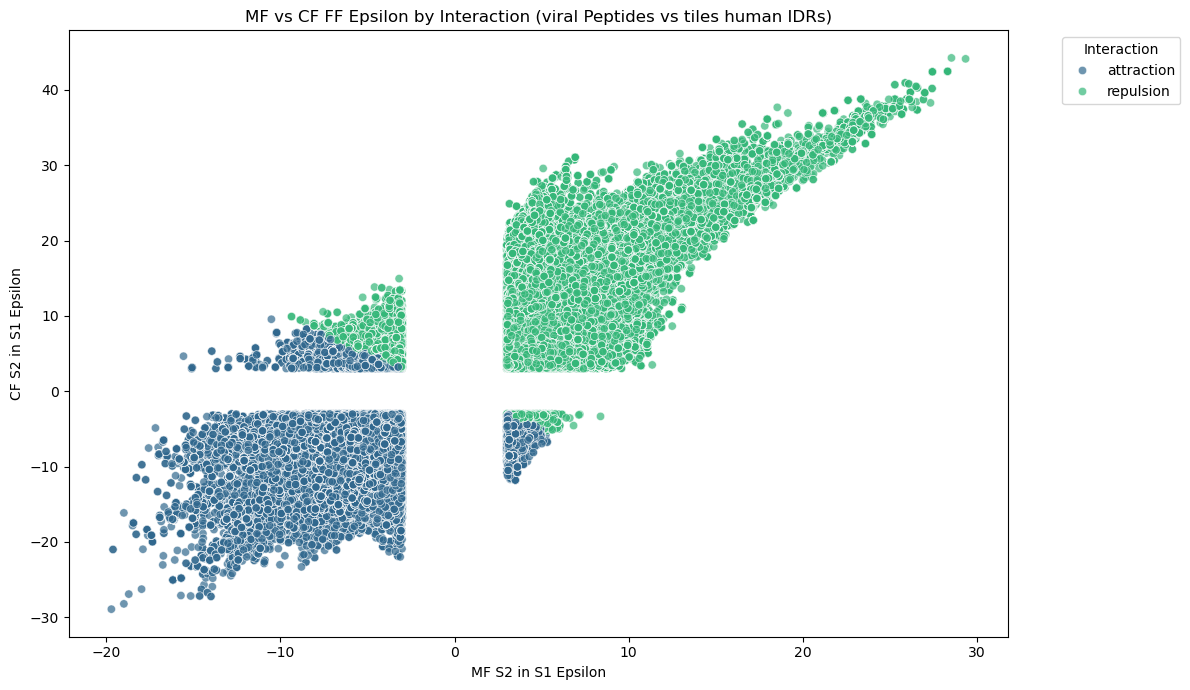

In [7]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='mf_s2_s1', y='cf_s2_s1',
                hue='interaction_type', alpha=0.7, palette='viridis')
plt.title('MF vs CF FF Epsilon by Interaction (viral Peptides vs tiles human IDRs)')
plt.xlabel('MF S2 in S1 Epsilon')
plt.ylabel('CF S2 in S1 Epsilon')
plt.legend(title='Interaction', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout() 
plt.show()

In [4]:
df_melted = df_.melt(id_vars=['s1_id', 's2_id'],
                    value_vars=['mf_s1_s2', 'mf_s2_s1', 'cf_s1_s2', 'cf_s2_s1'],
                    var_name='metric_type',
                    value_name='value')

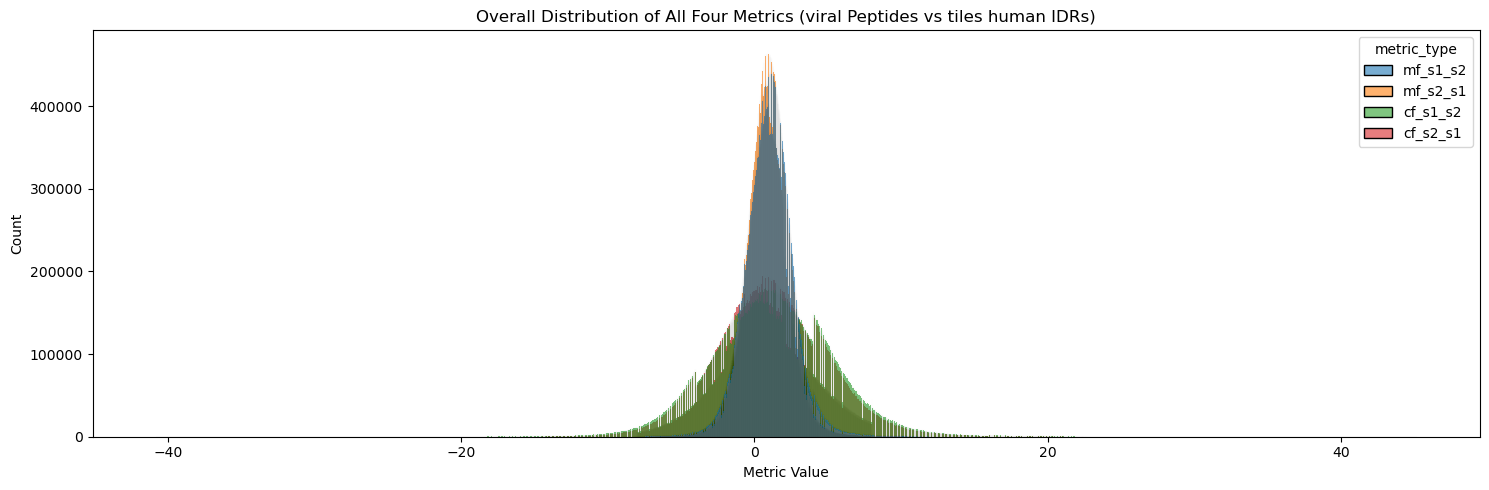

/scratch/1375004.1.apolkovnikov-pub/ipykernel_2403259/1076407787.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/projectnb/cancergrp/Philipp/.conda/envs/jupyter_env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


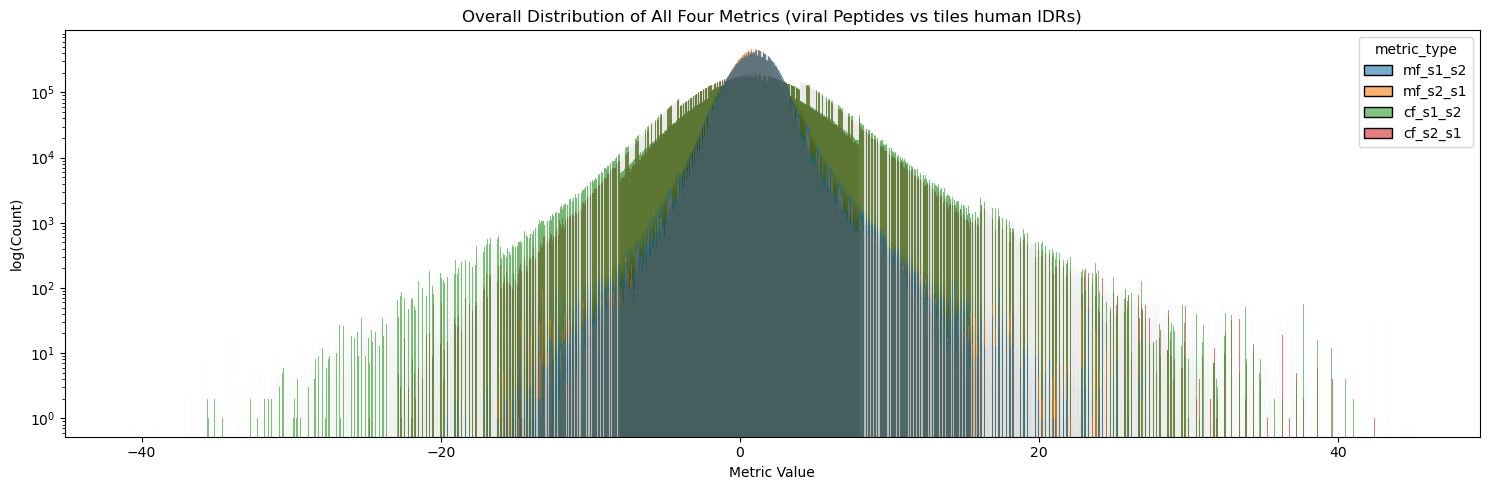

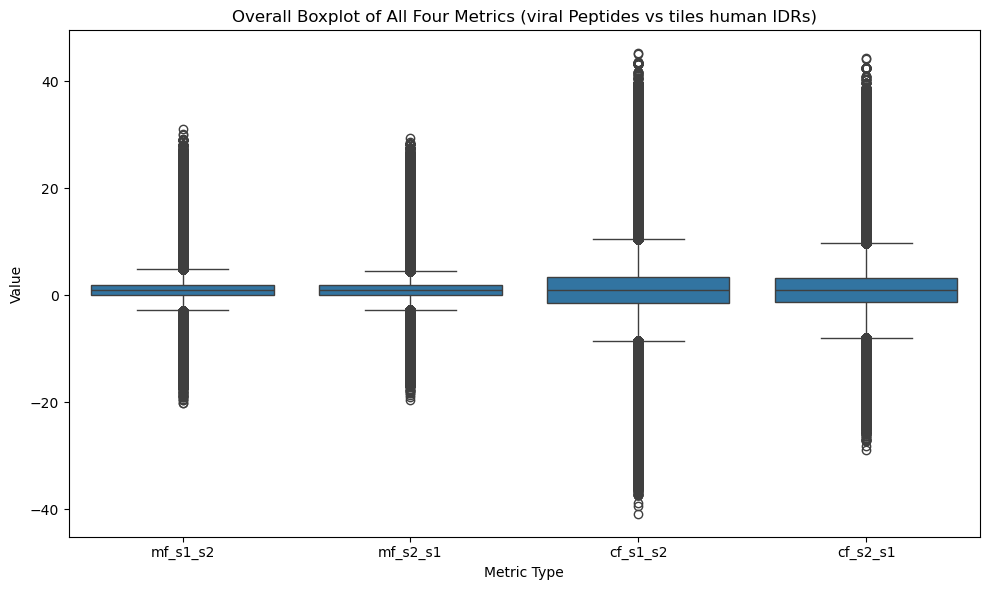

In [5]:
# Overall distribution of each metric
plt.figure(figsize=(15, 5))
ax = sns.histplot(data=df_melted, x='value', hue='metric_type', palette='tab10', alpha=0.6)
plt.title('Overall Distribution of All Four Metrics (viral Peptides vs tiles human IDRs)')
plt.xlabel('Metric Value')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Overall log distribution of each metric
plt.figure(figsize=(15, 5))
ax = sns.histplot(data=df_melted, x='value', hue='metric_type', palette='tab10', alpha=0.6)
plt.yscale('log')
plt.title('Overall Distribution of All Four Metrics (viral Peptides vs tiles human IDRs)')
plt.xlabel('Metric Value')
plt.ylabel('log(Count)')
plt.tight_layout()
plt.show()

# Boxplot comparing the overall distributions of the 4 metrics
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x='metric_type', y='value')
plt.title('Overall Boxplot of All Four Metrics (viral Peptides vs tiles human IDRs)')
plt.xlabel('Metric Type')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

In [15]:
df_melted_ = df_.melt(id_vars=['s1_id', 's2_id', 'P53_Interaction'],
                    value_vars=['mf_s1_s2', 'mf_s2_s1', 'cf_s1_s2', 'cf_s2_s1'],
                    var_name='metric_type',
                    value_name='value')

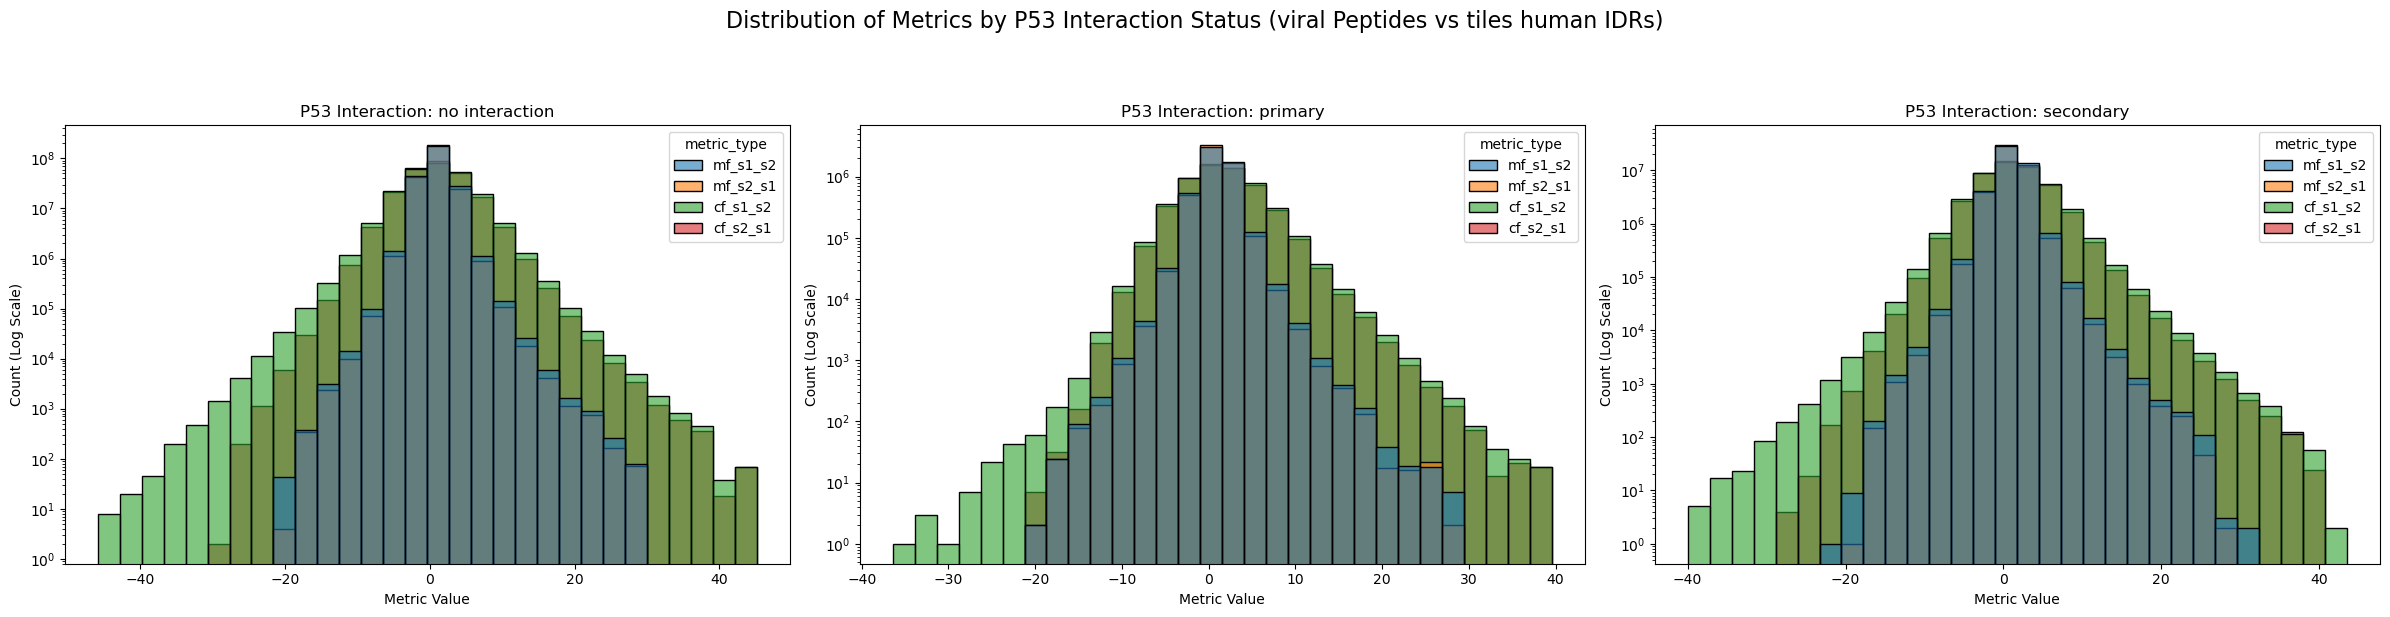

In [16]:
# Create a figure with subplots
# Use sharey=False because of log scale, which might have different ranges per subplot
fig, axes = plt.subplots(1, len(interaction_types), figsize=(8 * len(interaction_types), 6), sharey=False)

# Ensure 'axes' is always an array, even if there's only one subplot
if len(interaction_types) == 1:
    axes = [axes]

for i, interaction_type in enumerate(interaction_types):
    ax = axes[i]
    54##
    # Filter the melted DataFrame for the current interaction type
    data_for_plot = df_melted_[df_melted_['P53_Interaction'] == interaction_type]

    # --- Debugging check ---
    if data_for_plot.empty:
        print(f"Warning: No data for P53 Interaction: {interaction_type}. Skipping plot for this panel.")
        ax.set_title(f"P53 Interaction: {interaction_type}\n(No Data)")
        ax.axis('off') # Turn off axis for empty plots
        continue
    # --- End debugging check ---

    # Plot the histogram on the current subplot
    sns.histplot(data=data_for_plot, x='value', hue='metric_type',
                 palette='tab10', alpha=0.6, multiple='layer', stat='count', bins=30, ax=ax)

    ax.set_yscale('log')
    ax.set_title(f'P53 Interaction: {interaction_type}')
    ax.set_xlabel('Metric Value')
    ax.set_ylabel('Count (Log Scale)')

    # --- FIX for empty legend: Explicitly get handles and labels ---
    handles, labels = ax.get_legend_handles_labels()
    if handles and labels: # Only add legend if there are items to show
        ax.legend(handles=handles, labels=labels, title='Metric Type', loc='best') # Add legend to each subplot
    else:
        print(f"Warning: No legend items generated for P53 Interaction: {interaction_type}. Check 'metric_type' column.")

# Add a main title for the entire figure
plt.suptitle('Distribution of Metrics by P53 Interaction Status (viral Peptides vs tiles human IDRs)', y=1.05, fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent suptitle from overlapping
plt.show()

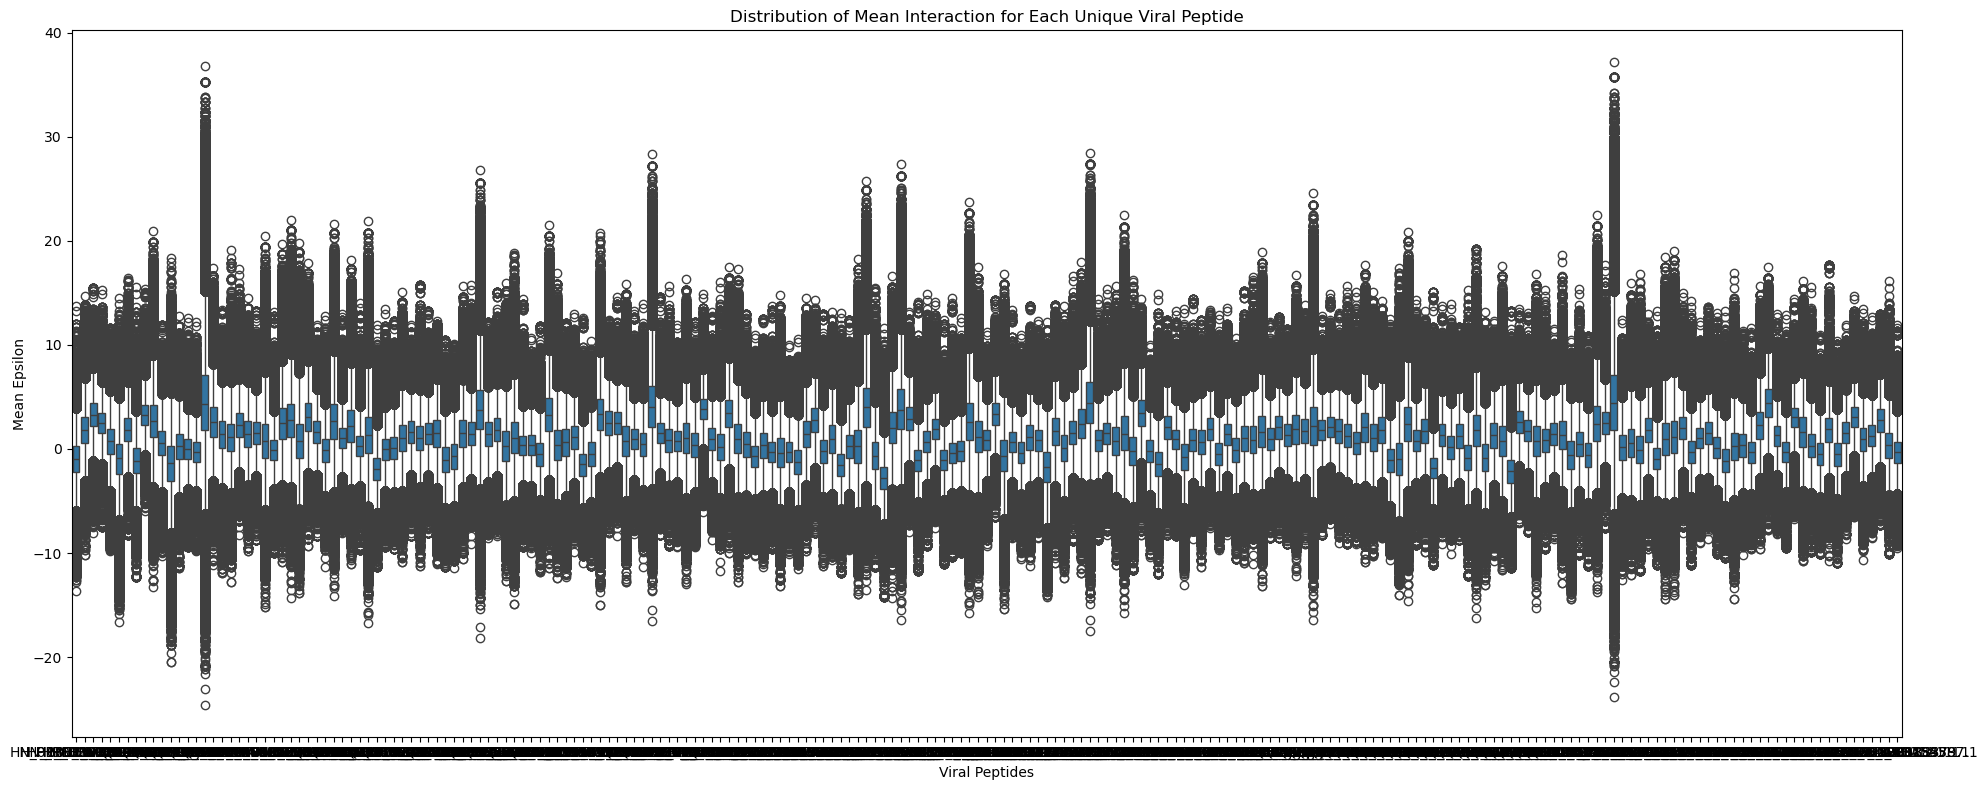

In [5]:
# Boxplot comparing the overall distributions of the 4 metrics
plt.figure(figsize=(20, 8))
sns.boxplot(data=df_, x='s1_id', y='mean_epsilon')
plt.title('Distribution of Mean Interaction for Each Unique Viral Peptide')
plt.xlabel('Viral Peptides')
plt.ylabel('Mean Epsilon')
plt.tight_layout()
plt.show()